In [1]:
import fitsio as fio
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
cent = fio.FITS('/lsst/troxel/y1a1/lgt20_central_p20.fits')[-1] # Central galaxy catalog (with shapes)
sat = fio.FITS('/lsst/troxel/y1a1/lgt20_satellite_p20.fits')[-1] # Satellite p_mem >= 0.2 catalog

In [3]:
sat_id_unq, counts = np.unique(sat['MEM_MATCH_ID'].read(), return_counts=True)
clus_n = len(sat_id_unq)
sat_max = np.amax(counts)

In [4]:
# Create 2D array for specified property of all satellite galaxies
def sat_prop(prop):
    sat_prop_full = sat[prop].read()
    new_array = np.zeros((clus_n,sat_max))
    k = 0
    for i in range(clus_n):
        new_array[i, 0:counts[i]] = sat_prop_full[k:k+counts[i]]
        new_array[i, counts[i]:] = np.nan
        k = k + counts[i]
    
    return new_array

In [5]:
# Calculate satellite angular position for all clusters
def sat_ang_pos():
    sat_ra = np.radians(sat_prop('RA'))
    sat_dec = np.radians(sat_prop('DEC'))
    cent_ra = np.radians(cent['RA'].read().reshape(clus_n,-1))
    cent_dec = np.radians(cent['DEC'].read().reshape(clus_n,-1))
    x = np.sin(sat_dec) * np.cos(cent_dec) - np.cos(sat_dec) * np.sin(cent_dec) * np.cos(sat_ra-cent_ra)
    y = np.sin(sat_ra-cent_ra) * np.cos(sat_dec)
    theta = np.arctan2(y, x)
    
    return theta

In [6]:
# Count satellite galaxies in each quadrant with specified axis angle
#def q_counts(theta):
    #sat_pos = np.degrees(sat_ang_pos()) + 180
    #nan_mask = np.isnan(sat_pos)
    #sat_pos[nan_mask] = 999.
    #theta = theta + 180
    #q1_count = np.sum(np.logical_and(np.less_equal(theta-180, sat_pos), np.less(sat_pos, theta-90)), axis=1)
    #q2_count = np.sum(np.logical_and(np.less_equal(theta-90, sat_pos), np.less(sat_pos, theta)), axis=1)
    #q3_count = np.sum(np.logical_and(np.less_equal(theta, sat_pos), np.less(sat_pos, theta+90)), axis=1)
    #q4_count = np.sum(np.logical_and(np.less_equal(theta+90, sat_pos), np.less(sat_pos, theta+180)), axis=1)
    #
    #return np.array([q1_count, q2_count, q3_count, q4_count])

In [7]:
def q_counts(theta):
    theta = np.radians(theta)
    sat_pos = sat_ang_pos()
    nan_mask = np.isnan(sat_pos)
    dif = sat_pos - theta
    x = np.cos(dif)
    y = np.sin(dif)
    x[nan_mask] = 0
    y[nan_mask] = 0
    q1 = np.sum(np.logical_and(x>0, y>0), axis=1)
    q2 = np.sum(np.logical_and(x<0, y>0), axis=1)
    q3 = np.sum(np.logical_and(x<0, y<0), axis=1)
    q4 = np.sum(np.logical_and(x>0, y<0), axis=1)
    
    return np.array([q1, q2, q3, q4])

In [8]:
def q_std(theta):
    q_i = q_counts(theta)
    std = np.std(q_i, axis=0)
    
    return std

In [9]:
def q_array(n):
    new_array = np.zeros((n, clus_n))
    for i in range(n):
        std_i = q_std(90*i/n)
        new_array[i] = std_i
    
    return new_array

In [10]:
def q_array_2(n):
    new_array = np.zeros((n, clus_n))
    for i in range(n):
        std_i = q_std(90*i/n+45)
        new_array[i] = std_i
    
    return new_array

In [11]:
def q_axis(n):
    std_array = q_array(n)
    std_sort = np.argmin(std_array, axis=0)
    n_ang = np.arange(n)*90/n
    thetas = n_ang[std_sort]
    
    return thetas

In [12]:
def q_axis_dif(n):
    std_1 = q_array(n)
    std_2 = q_array_2(n)
    std_dif = std_2 - std_1
    dif_min = np.amin(std_dif, axis=0)
    mask = std_dif==dif_min
    min_counts = np.sum(mask, axis=0)
    unq = np.sum(min_counts==1)
    print(unq)
    std_sort = np.argmax(std_dif, axis=0)
    n_ang = np.arange(n)*90/n
    thetas = n_ang[std_sort]
    
    return thetas

In [13]:
def q_rand(n):
    std_array = q_array(n)
    std_min = np.amin(std_array, axis=0)
    mask = std_array==std_min
    min_count = np.sum(mask, axis=0)
    rand = np.random.random(clus_n)
    rand_min = np.rint((min_count-1)*rand).astype(int)
    mask_t = np.transpose(mask)
    n_clus, indeces = np.where(mask_t)
    shift = np.zeros(clus_n, dtype=int)
    shift[1:] = np.cumsum(min_count[:-1], dtype=int)
    rand_select = rand_min + shift
    std_sort = indeces[rand_select]
    n_ang = np.arange(n)*90/n
    thetas = n_ang[std_sort]
    
    return thetas

In [14]:
def q_dif_rand(n):
    std_1 = q_array(n)
    std_2 = q_array_2(n)
    std_dif = std_2 - std_1
    std_min = np.amax(std_dif, axis=0)
    mask = std_dif==std_min
    max_count = np.sum(mask, axis=0)
    rand = np.random.random(clus_n)
    rand_max = np.rint((max_count-1)*rand).astype(int)
    mask_t = np.transpose(mask)
    n_clus, indeces = np.where(mask_t)
    shift = np.zeros(clus_n, dtype=int)
    shift[1:] = np.cumsum(max_count[:-1], dtype=int)
    rand_select = rand_max + shift
    std_sort = indeces[rand_select]
    n_ang = np.arange(n)*90/n
    thetas = n_ang[std_sort]
    
    return thetas

In [15]:
def q_major(n):
    q_axes = q_axis_dif(n)
    q_a = q_axes
    for i in range(n):
        mask = q_axes==90*i/n
        q_i = q_counts(90*i/n+45)
        comp = (q_i[0] + q_i[2]) - (q_i[1] + q_i[3])
        a_mask = comp > 0
        b_mask = np.logical_and(mask, a_mask)
        q_a[b_mask] = q_a[b_mask] - 90
    
    return q_a

In [16]:
def q_major_rand(n):
    q_axes = q_rand(n)
    q_a = q_axes
    for i in range(n):
        mask = q_axes==90*i/n
        q_i = q_counts(90*i/n+45)
        comp = (q_i[0] + q_i[2]) - (q_i[1] + q_i[3])
        a_mask = comp > 0
        b_mask = np.logical_and(mask, a_mask)
        q_a[b_mask] = q_a[b_mask] - 90
    
    return q_a

In [17]:
def q_major_dif_rand(n):
    q_axes = q_dif_rand(n)
    q_a = q_axes
    for i in range(n):
        mask = q_axes==90*i/n
        q_i = q_counts(90*i/n+45)
        comp = (q_i[0] + q_i[2]) - (q_i[1] + q_i[3])
        a_mask = comp > 0
        b_mask = np.logical_and(mask, a_mask)
        q_a[b_mask] = q_a[b_mask] - 90
    
    return q_a

In [18]:
def pos_ang(e1, e2):
    alpha = np.arctan2(-e2, -e1) / 2
    
    return alpha

In [19]:
def clus_align_ang(n):
    clus_ang = np.radians(q_major(n))
    cent_ang = pos_ang(cent['e1'].read(), cent['e2'].read())
    delta = clus_ang - cent_ang
    delta = np.arcsin(np.abs(np.sin(delta)))
    delta = np.degrees(delta)
    
    return delta

In [20]:
def clus_align_rand(n):
    clus_ang = np.radians(q_major_rand(n))
    cent_ang = pos_ang(cent['e1'].read(), cent['e2'].read())
    delta = clus_ang - cent_ang
    delta = np.arcsin(np.abs(np.sin(delta)))
    delta = np.degrees(delta)
    
    return delta

In [21]:
def clus_align_dif_rand(n):
    clus_ang = np.radians(q_major_dif_rand(n))
    cent_ang = pos_ang(cent['e1'].read(), cent['e2'].read())
    delta = clus_ang - cent_ang
    delta = np.arcsin(np.abs(np.sin(delta)))
    delta = np.degrees(delta)
    
    return delta

16339


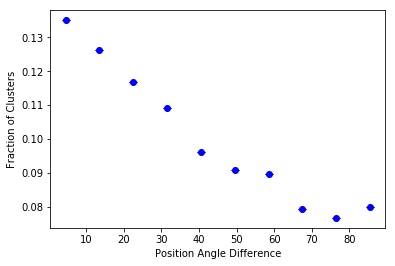

In [22]:
# Plot histogram of cluster alignment angle (with standard error of the mean)
clus_align = clus_align_ang(10)
n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = clus_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, fmt='bo', capsize=4)
plt.xlabel('Position Angle Difference')
plt.ylabel('Fraction of Clusters')
plt.show()

In [ ]:
# Plot histogram of cluster alignment angle (with standard error of the mean)
clus_align = clus_align_rand(90)
n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = clus_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, fmt='bo', capsize=4)
plt.xlabel('Position Angle Difference')
plt.ylabel('Fraction of Clusters')
plt.show()

In [ ]:
# Plot histogram of cluster alignment angle (with standard error of the mean)
clus_align = clus_align_dif_rand(90)
n, bins = np.histogram(clus_align, bins=[0.,9.,18.,27.,36.,45.,54.,63.,72.,81., 90.])
k = 0
new_array = np.zeros(10)
for i in range(10):
    bin_i = clus_align[k:k+n[i]]
    std_i = np.std(bin_i)
    sem_i = std_i/np.sqrt(n[i])
    new_array[i] = sem_i
    k = k + n[i]
plt.errorbar(bins[0:10]+4.5, n/clus_n, yerr=new_array/clus_n, fmt='bo', capsize=4)
plt.xlabel('Position Angle Difference')
plt.ylabel('Fraction of Clusters')
plt.show()

In [ ]:
q_90_dif_rand = q_major_dif_rand(90)
n, bins, patches = plt.hist(q_90_dif_rand)
plt.show

In [ ]:
np.mean(clus_align)